### Spark notebook ###

This notebook will only work in a Jupyter session running on `mathmadslinux2p`.

You can start your own Jupyter session on `mathmadslinux2p` and open this notebook in Chrome on the MADS Windows server by

**Steps**

1. Login to the MADS Windows server using https://mathportal.canterbury.ac.nz/.
2. Download or copy this notebook to your home directory.
3. Open powershell and run `ssh mathmadslinux2p`.
4. Run `start_pyspark_notebook` or `/opt/anaconda3/bin/jupyter-notebook --ip 132.181.129.68 --port $((8000 + $((RANDOM % 999))))`.
5. Copy / paste the url provided in the shell window into Chrome on the MADS Windows server.
6. Open the notebook from the Jupyter root directory (which is your home directory).
7. Run `start_spark()` to start a spark session in the notebook.
8. Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the Spark UI.

In [1]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

### Example notebook ###

The code below provides a template for how you would use a notebook to start spark, run some code, and then stop spark.

**Steps**

- Run `start_spark()` to start a spark session in the notebook (only change the default resources when advised to do so for an exercise or assignment)
- Write and run code interactively, creating additional cells as needed.
- Run `stop_spark()` before closing the notebook or kill your spark application by hand using the link in the [Spark UI](http://mathmadslinux2p.canterbury.ac.nz:8080/).

In [7]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.driver.memory,4g
spark.app.id,app-20240915153744-1098
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.ui.port,4509
spark.sql.warehouse.dir,file:/users/home/yya163/DATA420_lab/Assignment_1/spark-warehouse
spark.app.startTime,1726371463130
spark.executor.cores,2


In [21]:
# Import needed modules

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *

# Visualizations

## Q1 (a)

In [9]:
# Load the DataFrame from the Parquet file
stations_df = spark.read.parquet("./output/enriched_stations.parquet")
daily_df = spark.read.parquet("./output/daily.parquet")

In [11]:
# Define two core elements
two_core_elements = ["TMAX", "TMIN"]

# Filter the daily dataset to keep only TMAX and TMIN observations
tmax_tmin_df = daily_df.filter(F.col('Element').isin(two_core_elements))

# Join with stations_df to get CountryCode for filtering New Zealand stations
tmax_tmin_with_country = tmax_tmin_df.join(
    stations_df.select("ID", "CountryCode"), 
    on="ID", 
    how="left"
)

show_as_html(tmax_tmin_with_country)

,ID,Date,Element,Value,MeasurementFlag,QualityFlag,SourceFlag,ObservationTime,CountryCode
0,AE000041196,20100101,TMAX,259,None,None,S,None,AE
1,AE000041196,20100101,TMIN,120,None,None,S,None,AE
2,AEM00041194,20100101,TMAX,250,None,None,S,None,AE
3,AEM00041194,20100101,TMIN,168,None,None,S,None,AE
4,AEM00041217,20100101,TMAX,250,None,None,S,None,AE
5,AEM00041217,20100101,TMIN,146,None,None,S,None,AE
6,AEM00041218,20100101,TMAX,265,None,None,S,None,AE
7,AG000060390,20100101,TMAX,180,None,None,S,None,AG
8,AG000060590,20100101,TMAX,240,None,None,S,None,AG
9,AG000060590,20100101,TMIN,40,None,None,S,None,AG


In [15]:
# Filter for New Zealand (CountryCode == "NZ")
tmax_tmin_nz = tmax_tmin_with_country.filter(F.col("CountryCode") == "NZ")

# Convert 'Date' column to a proper date format before extracting the year
tmax_tmin_nz = tmax_tmin_nz.withColumn("ProperDate", F.to_date(F.col("Date").cast("string"), "yyyyMMdd"))

# Extract the year from the 'ProperDate' column
tmax_tmin_nz = tmax_tmin_nz.withColumn("Year", F.year(F.col("ProperDate")))

# Extract the month from the 'ProperDate' column
tmax_tmin_nz = tmax_tmin_nz.withColumn("Month", F.month(F.col("ProperDate")))

In [16]:
# Count the number of observations
num_observations = tmax_tmin_nz.count()

print(f"The number of observations in New Zealand: {num_observations}.")


The number of observations in New Zealand: 487760.


In [17]:
# Calculate the range of years covered
years_min = tmax_tmin_nz.agg({"Year": "min"}).collect()[0][0]
years_max = tmax_tmin_nz.agg({"Year": "max"}).collect()[0][0]
years_covered = f"{years_min} - {years_max}"

print(f"Years covered: {years_covered}")

Years covered: 1940 - 2024


In [18]:
import pandas as pd

# Convert to Pandas and save to CSV
tmax_tmin_nz_df = tmax_tmin_nz.toPandas()


# Convert temperature values from tenths of degrees to degrees
tmax_tmin_nz_df['Value'] = tmax_tmin_nz_df['Value'] / 10


tmax_tmin_nz_df.to_csv("tmax_tmin_nz.csv", index=False)

In [19]:
print(tmax_tmin_nz_df)

                 ID      Date Element  Value MeasurementFlag QualityFlag  \
0       NZ000093292  20100101    TMAX   29.7            None        None   
1       NZ000093292  20100101    TMIN    7.4            None        None   
2       NZ000093417  20100101    TMAX   18.0            None        None   
3       NZ000093417  20100101    TMIN   12.5            None        None   
4       NZ000093844  20100101    TMAX   23.2            None        None   
5       NZ000093844  20100101    TMIN    9.6            None        None   
6       NZ000933090  20100101    TMAX   19.7            None        None   
7       NZ000933090  20100101    TMIN    8.2            None        None   
8       NZ000936150  20100101    TMAX   32.4            None        None   
9       NZM00093110  20100101    TMAX   21.5            None        None   
10      NZM00093110  20100101    TMIN   15.3            None        None   
11      NZM00093439  20100101    TMAX   20.4            None        None   
12      NZM0

## Q1 (b)

#### Plot time series for TMIN and TMAX together for each station in New Zealand

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


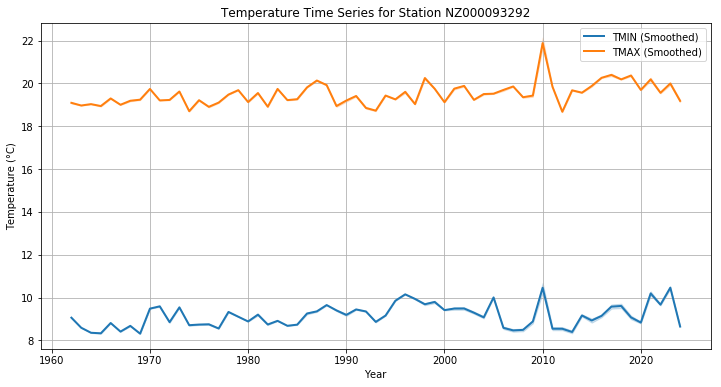

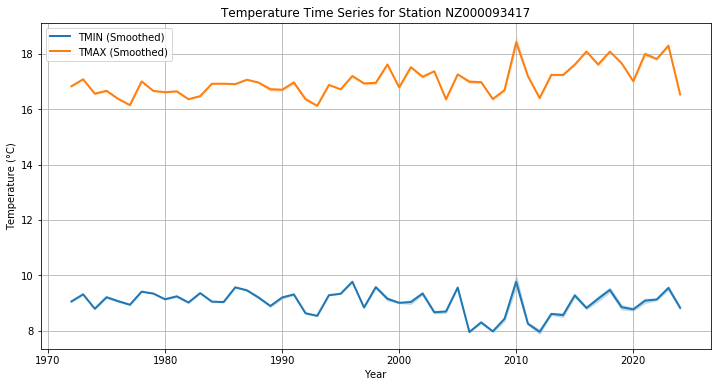

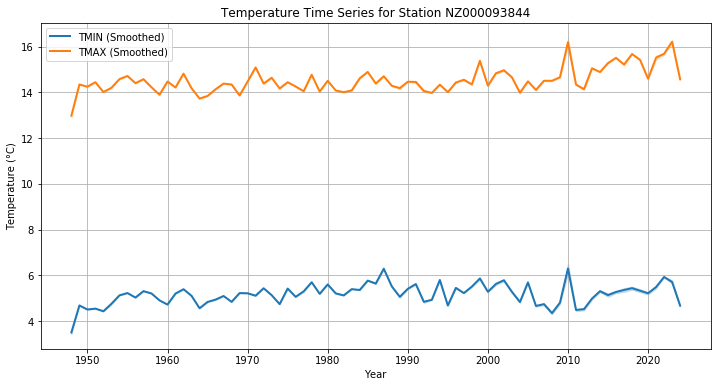

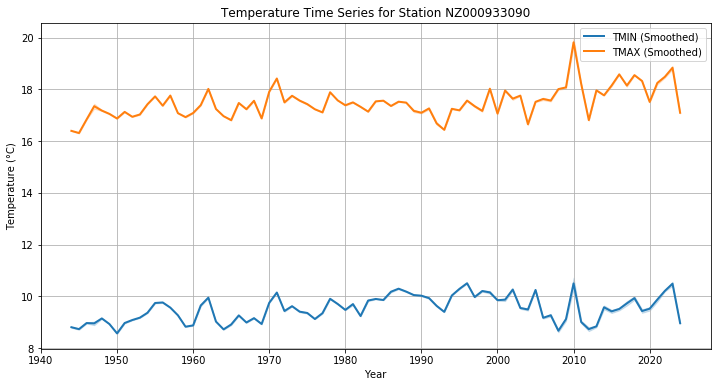

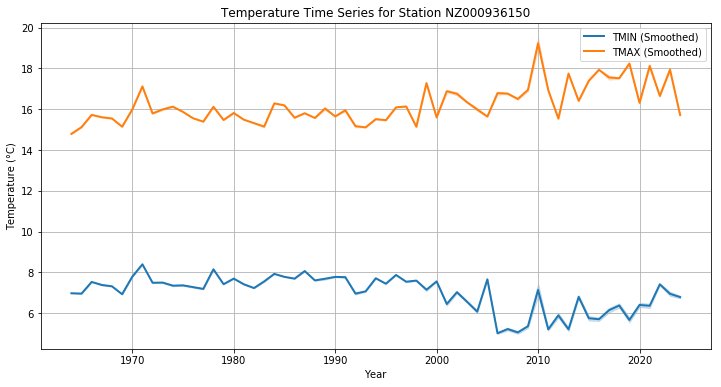

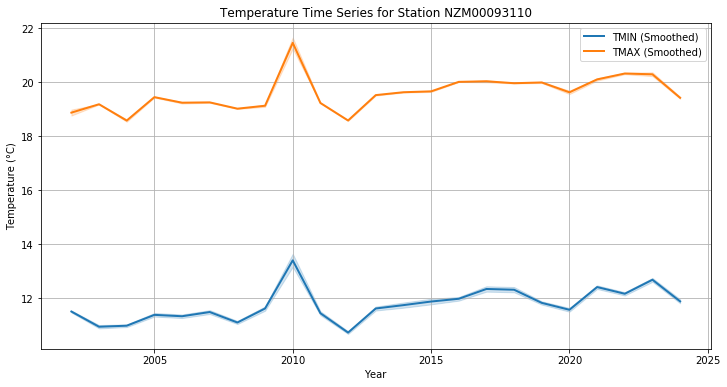

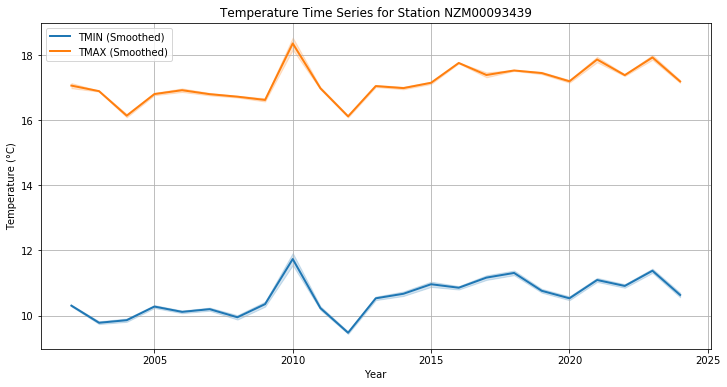

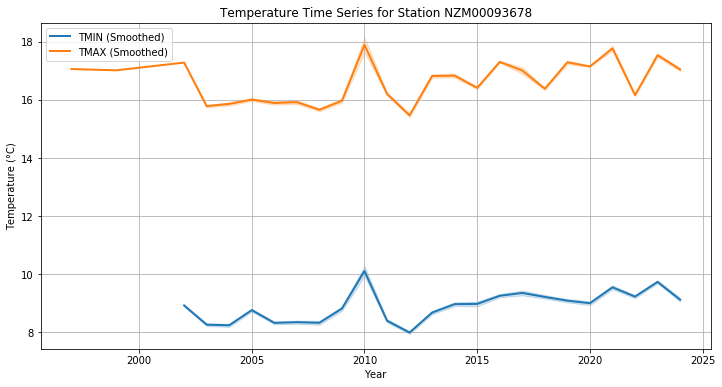

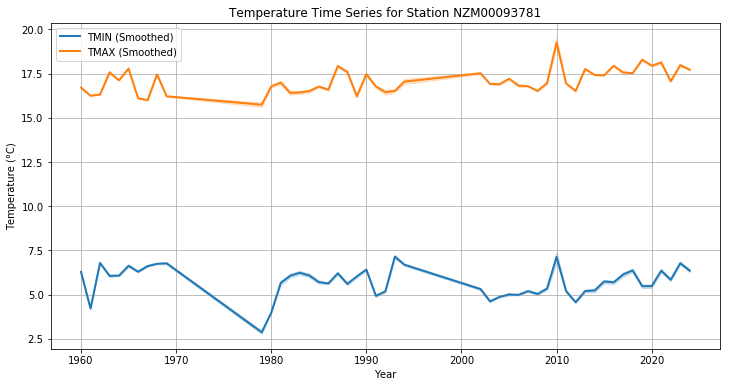

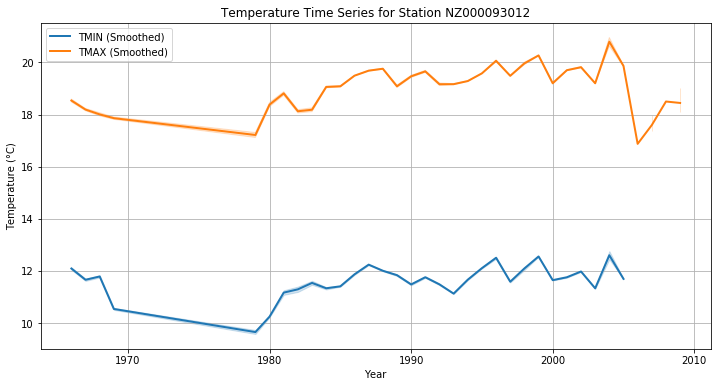

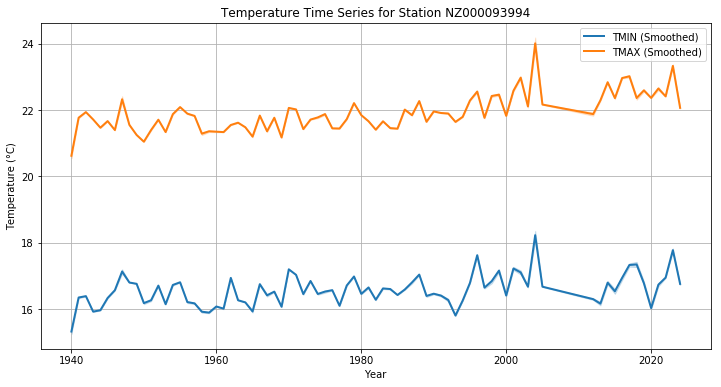

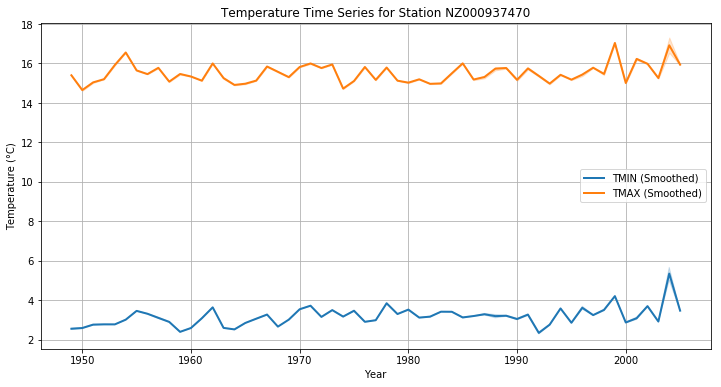

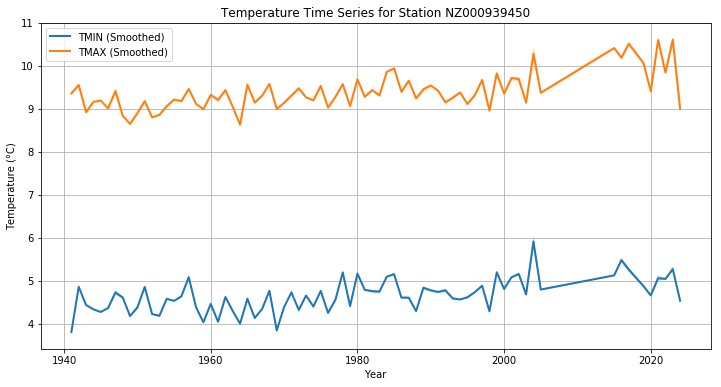

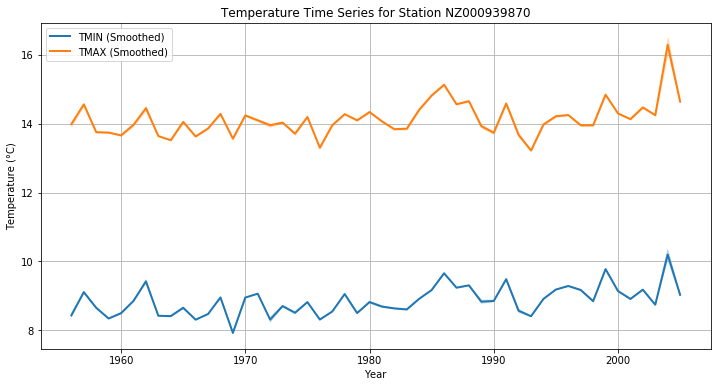

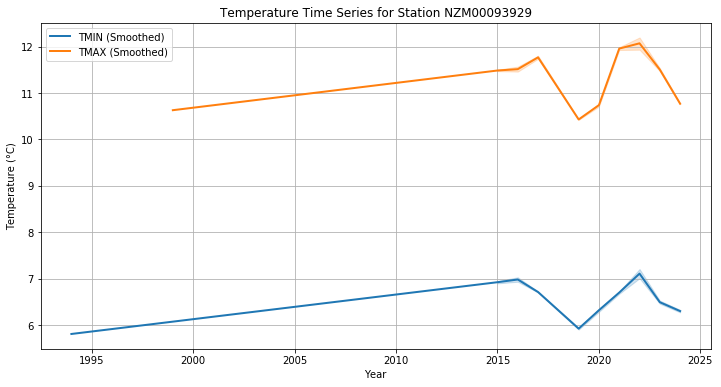

In [22]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the directory exists
os.makedirs('./plots', exist_ok=True)

# Define the function for plotting temperature time series for a given station
def plot_station_temps(data, station_id):
    plt.figure(figsize=(12, 6))
    
    for element in ['TMIN', 'TMAX']:
        # Filter the data for the station and element
        station_data = data[(data['ID'] == station_id) & (data['Element'] == element)].copy()
        
        # Calculate rolling average
        rolling_window_size = 365
        station_data['VALUE_SMOOTHED'] = station_data['Value'].rolling(window=rolling_window_size, min_periods=1).mean()

        # Plot the smoothed data using the 'Year' column as the x-axis
        sns.lineplot(x='Year', y='VALUE_SMOOTHED', data=station_data, label=f'{element} (Smoothed)', linewidth=2)
    
    plt.title(f"Temperature Time Series for Station {station_id}")
    plt.xlabel("Year")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid()

    # Save the plot to ./plots folder
    save_path = f"./plots/temperature_station_{station_id}.png"
    plt.savefig(save_path)

    # Show the plot
    plt.show()

# Plot for each station
for station_id in tmax_tmin_nz_df['ID'].unique():
    plot_station_temps(tmax_tmin_nz_df, station_id)


#### Plot the average time series for TMIN and TMAX

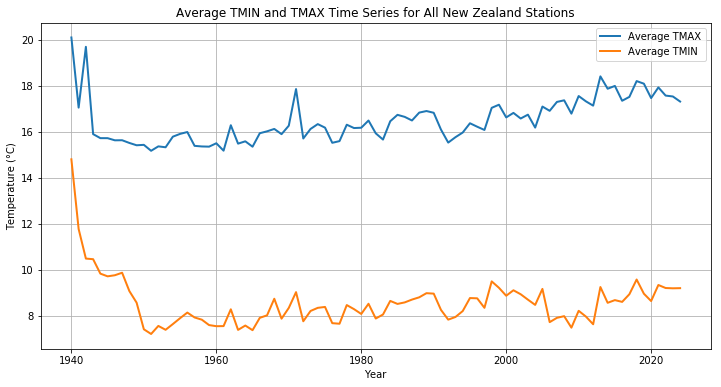

In [23]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the directory exists
os.makedirs('./plots', exist_ok=True)

# Group by Year and Element (TMAX/TMIN), and calculate the average Value for the entire country
average_tmin_tmax_country = tmax_tmin_nz_df.groupby(['Year', 'Element'])['Value'].mean().unstack()

# Plot the average time series for TMIN and TMAX for the entire country
plt.figure(figsize=(12, 6))

# Plot TMAX
plt.plot(average_tmin_tmax_country.index, average_tmin_tmax_country['TMAX'], label='Average TMAX', linewidth=2)

# Plot TMIN
plt.plot(average_tmin_tmax_country.index, average_tmin_tmax_country['TMIN'], label='Average TMIN', linewidth=2)

# Add titles and labels
plt.title('Average TMIN and TMAX Time Series for All New Zealand Stations')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()

# Save the average plot as a PNG file
plt.savefig('./plots/average_tmin_tmax_nz_country.png')

# Show the plot
plt.show()

## Q2 (a)

In [26]:
from pyspark.sql.functions import year, to_date, col
import pandas as pd

rainfall_daily_df = daily_df.filter(col('Element') == 'PRCP')

# Join with stations_df to get CountryCode for filtering New Zealand stations
rainfall_df = rainfall_daily_df.join(
    stations_df.select("ID", "CountryCode", "CountryName"), 
    on="ID", 
    how="left"
)
show_as_html(rainfall_df)

,ID,Date,Element,Value,MeasurementFlag,QualityFlag,SourceFlag,ObservationTime,CountryCode,CountryName
0,AEM00041194,20100101,PRCP,0,None,None,S,None,AE,United Arab Emirates
1,AG000060390,20100101,PRCP,0,None,None,S,None,AG,Algeria
2,AG000060590,20100101,PRCP,0,None,None,S,None,AG,Algeria
3,AG000060611,20100101,PRCP,0,None,None,S,None,AG,Algeria
4,AGE00147708,20100101,PRCP,5,None,None,S,None,AG,Algeria
5,AGE00147716,20100101,PRCP,5,None,None,S,None,AG,Algeria
6,AGE00147718,20100101,PRCP,0,None,None,S,None,AG,Algeria
7,AGM00060351,20100101,PRCP,0,None,None,S,None,AG,Algeria
8,AGM00060355,20100101,PRCP,0,None,None,S,None,AG,Algeria
9,AGM00060360,20100101,PRCP,0,None,None,S,None,AG,Algeria


In [27]:
# Convert 'Date' column to a proper date format
rainfall_df = rainfall_df.withColumn("DateFormatted", to_date(col("Date"), "yyyyMMdd"))

# Extract the year from the 'DateFormatted' column
rainfall_df = rainfall_df.withColumn("Year", year(col("DateFormatted")))

# Convert rainfall from tenths of mm to mm
rainfall_df_converted = rainfall_df.withColumn('Value', F.col('Value') / 10)

# Show the updated dataframe with the 'Year' column
show_as_html(rainfall_df_converted)

,ID,Date,Element,Value,MeasurementFlag,QualityFlag,SourceFlag,ObservationTime,CountryCode,CountryName,DateFormatted,Year
0,AEM00041194,20100101,PRCP,0.0,None,None,S,None,AE,United Arab Emirates,2010-01-01,2010
1,AG000060390,20100101,PRCP,0.0,None,None,S,None,AG,Algeria,2010-01-01,2010
2,AG000060590,20100101,PRCP,0.0,None,None,S,None,AG,Algeria,2010-01-01,2010
3,AG000060611,20100101,PRCP,0.0,None,None,S,None,AG,Algeria,2010-01-01,2010
4,AGE00147708,20100101,PRCP,0.5,None,None,S,None,AG,Algeria,2010-01-01,2010
5,AGE00147716,20100101,PRCP,0.5,None,None,S,None,AG,Algeria,2010-01-01,2010
6,AGE00147718,20100101,PRCP,0.0,None,None,S,None,AG,Algeria,2010-01-01,2010
7,AGM00060351,20100101,PRCP,0.0,None,None,S,None,AG,Algeria,2010-01-01,2010
8,AGM00060355,20100101,PRCP,0.0,None,None,S,None,AG,Algeria,2010-01-01,2010
9,AGM00060360,20100101,PRCP,0.0,None,None,S,None,AG,Algeria,2010-01-01,2010


In [28]:
# 1. Replace null values with 0
rainfall_df_clean = rainfall_df_converted.fillna({'Value': 0})

# 2. Calculate total rainfall for each station per year
annual_rainfall = rainfall_df_clean.groupBy('Year', 'CountryCode', 'CountryName', 'ID').agg(
    F.sum('Value').alias('AnnualTotalRainfall')
)

# 3. Calculate total rainfall and number of stations per country and year
annual_summary = annual_rainfall.groupBy('Year', 'CountryCode', 'CountryName').agg(
    F.sum('AnnualTotalRainfall').alias('TotalRainfall'),  # Total rainfall
    F.countDistinct('ID').alias('StationCount')  # Count the number of unique stations
)

# 4. Calculate the average rainfall per country per year (total rainfall divided by number of stations)
avg_rainfall_by_country = annual_summary.withColumn(
    'AverageRainfall', F.col('TotalRainfall') / F.col('StationCount')
)

# 5. Show the result
show_as_html(avg_rainfall_by_country)


,Year,CountryCode,CountryName,TotalRainfall,StationCount,AverageRainfall
0,2008,EI,Ireland,14490.2,12,1207.516667
1,2008,GL,Greenland [Denmark],11604.8,14,828.914286
2,2008,MY,Malaysia,47166.9,14,3369.064286
3,2008,TU,Turkey,17137.7,37,463.181081
4,2004,AY,Antarctica,20965.6,19,1103.452632
5,2004,KS,"Korea, South",15727.9,11,1429.809091
6,2005,IO,British Indian Ocean Territory [United Kingdom],3442.0,1,3442.000000
7,2023,MF,Mayotte [France],792.5,1,792.500000
8,2016,NL,Netherlands,294270.6,348,845.605172
9,2001,FJ,Fiji,48926.6,22,2223.936364


In [49]:
# Generate descriptive statistics for average rainfall
avg_rainfall_stats = avg_rainfall_by_country.select('AverageRainfall').describe().toPandas()
print(avg_rainfall_stats)

  summary     AverageRainfall
0   count               17548
1    mean   815.2990053549645
2  stddev   785.6643984083775
3     min  -39.29999999999984
4     max             16589.0


In [60]:
# Find the country with the highest average rainfall in a single year
highest_avg_rainfall = avg_rainfall_by_country.orderBy(F.desc('AverageRainfall')).first()

# Print the result
print(f"Country with highest average rainfall in a single year: {highest_avg_rainfall['CountryName']} in the year {highest_avg_rainfall['Year']} with {highest_avg_rainfall['AverageRainfall']} mm of rainfall")

Country with highest average rainfall in a single year: New Caledonia [France] in the year 1967 with 16589.0 mm of rainfall


#### Dealing with outliers before final visualization

In [13]:
# 1. Filter out records with negative rainfall values
rainfall_df_clean = rainfall_df_converted.fillna({'Value': 0})

# 2. Remove records with negative rainfall values
rainfall_df_filtered = rainfall_df_clean.filter(F.col('Value') >= 0)

# 3. Set a reasonable upper limit for daily rainfall (e.g., 300 mm)
max_daily_rainfall = 300
rainfall_df_filtered = rainfall_df_filtered.filter(F.col('Value') <= max_daily_rainfall)


# 4. Calculate total rainfall for each station per year
annual_rainfall = rainfall_df_filtered.groupBy('Year', 'CountryCode', 'CountryName', 'ID').agg(
    F.sum('Value').alias('AnnualTotalRainfall')
)

# 5. Calculate total rainfall and number of stations per country and year
annual_summary = annual_rainfall.groupBy('Year', 'CountryCode', 'CountryName').agg(
    F.sum('AnnualTotalRainfall').alias('TotalRainfall'),  # Total rainfall
    F.countDistinct('ID').alias('StationCount')  # Number of unique stations
)

# 6. Calculate the average rainfall per country per year
avg_rainfall_by_country = annual_summary.withColumn(
    'AverageRainfall', F.col('TotalRainfall') / F.col('StationCount')
)

# 7. Descriptive statistics
avg_rainfall_stats2 = avg_rainfall_by_country.select('AverageRainfall').describe().toPandas()
print(avg_rainfall_stats2)

  summary    AverageRainfall
0   count              17546
1    mean  796.3444561981239
2  stddev  685.5478285195442
3     min                0.0
4     max             8324.0


In [14]:
# Save the result to output directory
avg_rainfall_by_country.write.mode("overwrite").csv("./output/avg_rainfall_by_country.csv")

In [29]:
avg_rainfall_pd = avg_rainfall_by_country.toPandas()

In [30]:
avg_rainfall_pd.to_csv("avg_rainfall_by_country.csv")

## Q2 (b)

Plot in a python file "avg_rainfall_2023".

In [31]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()